In [8]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow Version: 2.19.0
Num GPUs Available:  0


In [9]:
# --- Dataset Paths (IMPORTANT: Update these paths) ---
# Example for local machine:
train_data_path = "data/train"
val_data_path = "data/validation"

# --- Training Hyperparameters ---
IMG_SIZE = (224, 224) # Input image dimensions for MobileNetV2
BATCH_SIZE = 32
INITIAL_EPOCHS = 15 
FINE_TUNE_EPOCHS = 10 
INITIAL_LR = 1e-3 
FINE_TUNE_LR = 1e-5 

# --- Model Saving ---
MODEL_SAVE_PATH = 'best_image_classifier_model.keras' # Recommended format

# --- Fine-Tuning Layer ---
# Name of the layer in MobileNetV2 from which to start unfreezing for fine-tuning
# Common choices: 'block_13_expand', 'block_14_expand', 'block_15_expand', 'block_16_expand'
FINE_TUNE_LAYER_NAME = 'block_13_expand'

In [10]:
"""
Cell 3: Data Loading and Preprocessing
"""
# Verify if dataset folders exist
if not os.path.exists(train_data_path):
    raise FileNotFoundError(f"❌ Training data path '{train_data_path}' does not exist. Check your path.")
else:
    print(f"✅ Training data found at: {train_data_path}")

if not os.path.exists(val_data_path):
    raise FileNotFoundError(f"❌ Validation data path '{val_data_path}' does not exist. Check your path.")
else:
    print(f"✅ Validation data found at: {val_data_path}")

# Data augmentation & preprocessing for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Validation data should NOT be augmented, only rescaled
val_datagen = ImageDataGenerator(rescale=1./255)

# Load data using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary', # Assuming 2 classes; change to 'categorical' for more
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary', # Must match train_generator
    shuffle=False # No need to shuffle validation data
)

# Print class indices
print("\nClass Indices found by generator:", train_generator.class_indices)
num_classes = len(train_generator.class_indices)
if num_classes != 2 and train_generator.class_mode == 'binary':
     print(f"Warning: Found {num_classes} classes but class_mode is 'binary'. Ensure this is intended.")
elif num_classes > 2 and train_generator.class_mode != 'categorical':
     print(f"Warning: Found {num_classes} classes. Consider changing class_mode to 'categorical' and adjusting the final Dense layer.")

print(f"\nFound {train_generator.samples} training images belonging to {num_classes} classes.")
print(f"Found {validation_generator.samples} validation images belonging to {num_classes} classes.")


✅ Training data found at: data/train
✅ Validation data found at: data/validation
Found 795 images belonging to 2 classes.
Found 773 images belonging to 2 classes.

Class Indices found by generator: {'ather': 0, 'non ather': 1}

Found 795 training images belonging to 2 classes.
Found 773 validation images belonging to 2 classes.


Displaying sample augmented training images...


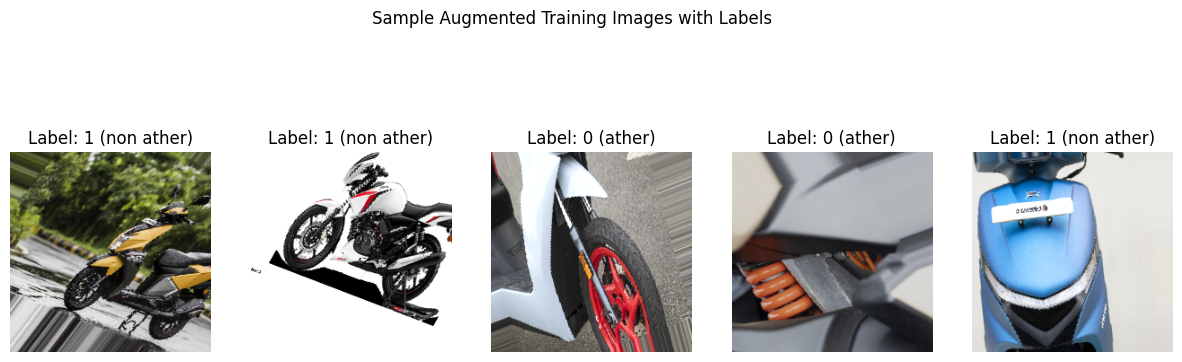

In [11]:
"""
Cell 4: Visualize Sample Data (Optional)
"""
def show_sample_images(generator):
    images, labels = next(generator) # Get a batch
    class_labels = {v: k for k, v in generator.class_indices.items()} # Map index to name

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle("Sample Augmented Training Images with Labels")
    for i in range(min(5, images.shape[0])): # Show up to 5 images or batch size
        axes[i].imshow(images[i])
        label_index = int(labels[i])
        axes[i].set_title(f"Label: {label_index} ({class_labels[label_index]})")
        axes[i].axis('off')
    plt.show()

# Show some training images
print("Displaying sample augmented training images...")
show_sample_images(train_generator)


In [12]:
"""
Cell 5: Model Building
"""
print("Building the model...")

# Load pre-trained base model
base_model = MobileNetV2(weights='imagenet',
                         include_top=False, # Exclude the final classification layer
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model layers initially
base_model.trainable = False
print(f"Base model '{base_model.name}' loaded. Initial trainable status: {base_model.trainable}")

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Experiment with Dense layer size if needed (e.g., 512, 256)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x) # Regularization
# Final layer: Dense(1, 'sigmoid') for binary classification
# For multi-class, use: Dense(num_classes, activation='softmax')
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Optional: Display model summary (can be very long)
# print("\nFull model summary (Top layers are trainable):")
# model.summary()


Building the model...
Base model 'mobilenetv2_1.00_224' loaded. Initial trainable status: False


In [13]:
"""
Cell 6: Initial Training Preparation
"""
print("Compiling model for initial training phase...")
model.compile(optimizer=Adam(learning_rate=INITIAL_LR),
              loss='binary_crossentropy', # Use 'categorical_crossentropy' for multi-class
              metrics=['accuracy'])

print("Setting up callbacks...")
# Save the best model based on validation accuracy
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH,
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='max') # Maximize validation accuracy

# Stop training if validation accuracy doesn't improve
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=7, # Number of epochs with no improvement
                               verbose=1,
                               mode='max',
                               restore_best_weights=True) # Restore weights from the best epoch

# Reduce learning rate if validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2, # New LR = LR * factor
                              patience=3,
                              verbose=1,
                              min_lr=1e-6, # Minimum learning rate
                              mode='min') # Minimize validation loss

callbacks_list = [checkpoint, early_stopping, reduce_lr]


Compiling model for initial training phase...
Setting up callbacks...


In [14]:
"""
Cell 7: Initial Training Execution
"""
print(f"\n--- Starting Initial Training (Top Layers Only) for up to {INITIAL_EPOCHS} epochs ---")

# Calculate steps per epoch ensuring it's at least 1
steps_per_epoch_train = max(1, train_generator.samples // BATCH_SIZE)
steps_per_epoch_val = max(1, validation_generator.samples // BATCH_SIZE)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_val,
    callbacks=callbacks_list
)

# Store history from this phase
acc = history.history.get('accuracy', [])
val_acc = history.history.get('val_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

print("\n--- Initial Training Phase Complete ---")
# Note: Early stopping might have finished training before INITIAL_EPOCHS



--- Starting Initial Training (Top Layers Only) for up to 15 epochs ---


d:\Projects\Ather\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
19/24 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6231 - loss: 0.9590

d:\Projects\Ather\.venv\Lib\site-packages\PIL\Image.py:3438: DecompressionBombWarning: Image size (95656288 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6290 - loss: 0.9309
Epoch 1: val_accuracy improved from -inf to 0.76302, saving model to best_image_classifier_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.6299 - loss: 0.9263 - val_accuracy: 0.7630 - val_loss: 0.4698 - learning_rate: 0.0010
Epoch 2/15
 1/24 ━━━━━━━━━━━━━━━━━━━━ 17s 744ms/step - accuracy: 0.6562 - loss: 0.7688

d:\Projects\Ather\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.76302 to 0.86458, saving model to best_image_classifier_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6562 - loss: 0.7688 - val_accuracy: 0.8646 - val_loss: 0.3580 - learning_rate: 0.0010
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8011 - loss: 0.4399
Epoch 3: val_accuracy did not improve from 0.86458
24/24 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.8008 - loss: 0.4400 - val_accuracy: 0.8424 - val_loss: 0.3192 - learning_rate: 0.0010
Epoch 4/15
 1/24 ━━━━━━━━━━━━━━━━━━━━ 18s 792ms/step - accuracy: 0.9688 - loss: 0.1558
Epoch 4: val_accuracy did not improve from 0.86458
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9688 - loss: 0.1558 - val_accuracy: 0.7917 - val_loss: 0.3789 - learning_rate: 0.0010
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8198 - loss: 0.3899
Epoch 5: val_accuracy improved from 0.86458 to 0.89583, saving model to best_image_classifier_model.keras
24/24 ━━━━━━━━━

In [15]:
"""
Cell 8: Fine-Tuning Preparation
"""
print("\n--- Preparing for Fine-Tuning Phase ---")

# Unfreeze the base model layers
base_model.trainable = True

# Find the index of the layer to fine-tune from
try:
    fine_tune_at_index = [i for i, layer in enumerate(base_model.layers) if layer.name == FINE_TUNE_LAYER_NAME][0]
    print(f"Identified fine-tune layer '{FINE_TUNE_LAYER_NAME}' at index {fine_tune_at_index}.")

    # Freeze all layers before the `fine_tune_at_index`
    print(f"Freezing layers up to index {fine_tune_at_index}...")
    for layer in base_model.layers[:fine_tune_at_index]:
        layer.trainable = False
    print("Layers frozen.")

    num_trainable_base = sum([1 for layer in base_model.layers if layer.trainable])
    print(f"Number of trainable layers in base model after unfreezing: {num_trainable_base}")

except IndexError:
    print(f"Warning: Layer '{FINE_TUNE_LAYER_NAME}' not found in base model. Fine-tuning all base layers.")
    # All layers in base_model remain trainable as set above

# Re-compile the model with a very low learning rate
print(f"Re-compiling model for fine-tuning with learning rate: {FINE_TUNE_LR}")
model.compile(optimizer=Adam(learning_rate=FINE_TUNE_LR), # Use the lower fine-tuning LR
              loss='binary_crossentropy', # Keep same loss and metrics
              metrics=['accuracy'])

# Optional: Display model summary again to see trainable layers
# print("\nModel summary after setting layers for fine-tuning:")
# model.summary()



--- Preparing for Fine-Tuning Phase ---
Identified fine-tune layer 'block_13_expand' at index 116.
Freezing layers up to index 116...
Layers frozen.
Number of trainable layers in base model after unfreezing: 38
Re-compiling model for fine-tuning with learning rate: 1e-05


In [16]:
"""
Cell 9: Fine-Tuning Execution
"""
# How many epochs were actually run in the initial phase?
initial_epochs_completed = len(val_acc) # Use length of history lists
total_epochs = initial_epochs_completed + FINE_TUNE_EPOCHS

print(f"\n--- Starting Fine-Tuning from epoch {initial_epochs_completed} for up to {FINE_TUNE_EPOCHS} more epochs (total {total_epochs}) ---")

# Continue training, using 'initial_epoch' to keep history continuous
history_fine = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=total_epochs,
    initial_epoch=initial_epochs_completed, # Start counting from here
    validation_data=validation_generator,
    validation_steps=steps_per_epoch_val,
    callbacks=callbacks_list # Reuse the same callbacks (EarlyStopping might trigger)
)

print("\n--- Fine-Tuning Phase Complete ---")

# Append the fine-tuning history to the initial history
acc.extend(history_fine.history.get('accuracy', []))
val_acc.extend(history_fine.history.get('val_accuracy', []))
loss.extend(history_fine.history.get('loss', []))
val_loss.extend(history_fine.history.get('val_loss', []))



--- Starting Fine-Tuning from epoch 15 for up to 10 more epochs (total 25) ---
Epoch 16/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8852 - loss: 0.2695
Epoch 16: val_accuracy improved from 0.95312 to 0.95703, saving model to best_image_classifier_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.8849 - loss: 0.2701 - val_accuracy: 0.9570 - val_loss: 0.1367 - learning_rate: 1.0000e-05
Epoch 17/25
 1/24 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9375 - loss: 0.1878
Epoch 17: val_accuracy did not improve from 0.95703
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9375 - loss: 0.1878 - val_accuracy: 0.9570 - val_loss: 0.1364 - learning_rate: 1.0000e-05
Epoch 18/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8987 - loss: 0.2524
Epoch 18: val_accuracy improved from 0.95703 to 0.96354, saving model to best_image_classifier_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.8990 - loss: 0.2519 - val_accuracy: 0.9635 - val_loss: 0.1260 


Plotting training history...


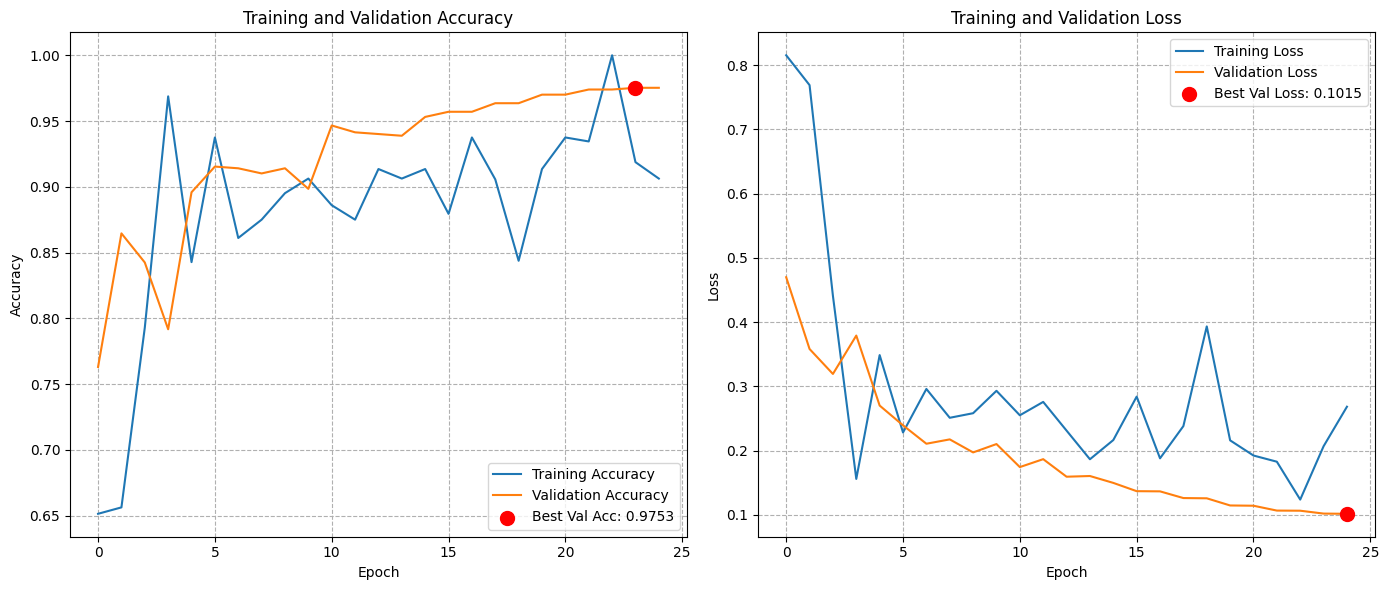

In [17]:
"""
Cell 10: Visualize Training Results
"""
print("\nPlotting training history...")

epochs_range = range(len(acc)) # Total number of epochs actually run

plt.figure(figsize=(14, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# Highlight the best validation accuracy epoch
if val_acc: # Check if list is not empty
    best_epoch_acc = np.argmax(val_acc)
    plt.scatter(best_epoch_acc, val_acc[best_epoch_acc], s=100, color='red', label=f'Best Val Acc: {val_acc[best_epoch_acc]:.4f}', zorder=5)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# Highlight the best validation loss epoch
if val_loss: # Check if list is not empty
    best_epoch_loss = np.argmin(val_loss)
    plt.scatter(best_epoch_loss, val_loss[best_epoch_loss], s=100, color='red', label=f'Best Val Loss: {val_loss[best_epoch_loss]:.4f}', zorder=5)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--')

plt.tight_layout()
plt.show()


In [18]:
"""
Cell 11: Evaluate Best Model
"""
print(f"\n--- Evaluating Best Model ---")
print(f"Loading best model saved at: {MODEL_SAVE_PATH}")

try:
    # Load the best model saved by ModelCheckpoint
    best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    print("Model loaded successfully.")

    print("\nEvaluating the best model on the validation dataset...")
    results = best_model.evaluate(validation_generator,
                                 steps=steps_per_epoch_val, # Use same steps as during training
                                 verbose=1)

    print("\nEvaluation Results (Best Model):")
    print(f"Validation Loss: {results[0]:.4f}")
    print(f"Validation Accuracy: {results[1]:.4f}")

except Exception as e:
    print(f"\n❌ Error loading the best model from {MODEL_SAVE_PATH}: {e}")
    print("You might need to check if the file exists or if training completed successfully.")
    print("Evaluating the final model state instead (if available)...")
    if 'model' in locals():
         results = model.evaluate(validation_generator, steps=steps_per_epoch_val, verbose=1)
         print("\nEvaluation Results (Final Model State):")
         print(f"Validation Loss: {results[0]:.4f}")
         print(f"Validation Accuracy: {results[1]:.4f}")
    else:
        print("Final model state not available for evaluation.")
print("\n✅ Notebook execution finished.")


--- Evaluating Best Model ---
Loading best model saved at: best_image_classifier_model.keras
Model loaded successfully.

Evaluating the best model on the validation dataset...
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9711 - loss: 0.1281

Evaluation Results (Best Model):
Validation Loss: 0.1018
Validation Accuracy: 0.9753

✅ Notebook execution finished.
